<a href="https://colab.research.google.com/github/SonKayyum/UrbanSoundsClassification/blob/main/UrbanSounds8K_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import librosa
import librosa.display
import matplotlib.pyplot as plt
import cv2
import random
import time
import os

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Drive'dan veri çekiyoruz ve bağlantıyı kontrol etmek için deneme bir .csv çektik.

In [5]:
df = pd.read_csv('/content/drive/MyDrive/UrbanSound8K.csv')
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [ ]:
#Proje kapsamında verilen spektrogramlar zip dosyasından çıkartılıyor.

In [ ]:
 !unzip '/content/drive/MyDrive/spectrograms.zip'

In [ ]:
#Bu kısım ön işleme kısmını oluşturmaktadır. Grayscale dönüşümü ve resizing yapıldı. Ardından listeye eklendiler. , X_train, y_train, X_val, y_val, X_test ve y_test olmak üzere veri setleri oluşturuldu. Veri setleri drive'a kaydedildi.

In [7]:
imgs= []
labels= []
for etiket in range(10):
  img_array=os.listdir("/content/spectrograms/"+str(etiket))  

  for img_iter in range(len(img_array)):
    img_gray=cv2.imread("/content/spectrograms/"+str(etiket)+"/"+img_array[img_iter],0)

    resized_gray = cv2.resize(img_gray, (100, 100), interpolation = cv2.INTER_AREA)

    normalized_gray=resized_gray/255
    
    imgs.append(normalized_gray)
    labels.append(etiket)

dict_ = list(zip(imgs, labels))
random.seed(10)
random.shuffle(dict_)
imgs, labels = zip(*dict_)

imgs=np.array(imgs)
labels=np.array(labels)

In [8]:
def train_valid_test(imgs, labels, train_percentage = 0.7, valid_percentage = 0.15):
  size=len(imgs)

  X_train=imgs[:int(train_percentage*size)]
  X_val=imgs[int(train_percentage*size):int((train_percentage+valid_percentage)*size)]
  X_test=imgs[int((train_percentage+valid_percentage)*size):]

  y_train=labels[:int(train_percentage*size)]
  y_val=labels[int(train_percentage*size):int((train_percentage+valid_percentage)*size)]
  y_test=labels[int((train_percentage+valid_percentage)*size):]

  return X_train, y_train, X_val, y_val, X_test, y_test

In [9]:
X_train, y_train, X_val, y_val, X_test, y_test= train_valid_test(imgs, labels)

In [10]:
print(f"X_train: {len(X_train)}")
print(f"X_val: {len(X_val)}")
print(f"X_test: {len(X_test)}")
print(f"y_train: {len(y_train)}")
print(f"y_val: {len(y_val)}")
print(f"y_test: {len(y_test)}")

X_train: 6112
X_val: 1310
X_test: 1310
y_train: 6112
y_val: 1310
y_test: 1310


In [11]:
np.save('/content/drive/MyDrive/X_train.npy', X_train)
np.save('/content/drive/MyDrive/X_val.npy', X_val)
np.save('/content/drive/MyDrive/X_test.npy', X_test)
np.save('/content/drive/MyDrive/y_train.npy', y_train)
np.save('/content/drive/MyDrive/y_val.npy', y_val)
np.save('/content/drive/MyDrive/y_test.npy', y_test)

In [ ]:
#Burada modelimizi oluşturuyoruz. Model eğitiliyor, performans metriklerini, loss ve accuracy oranlarını da yazdırdık. Plot çizerek şekillendirdik. 

In [26]:
model=tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(32,
                                 kernel_size=(3,3),
                                 strides=(1,1),
                                 padding="valid",
                                 activation="relu",
                                 input_shape=(100,100,1))) 
model.add(tf.keras.layers.Conv2D(64,
                                 kernel_size=(3,3),
                                 strides=(1,1),
                                 padding="valid",
                                 activation="relu"))
model.add(tf.keras.layers.MaxPool2D((2,2)))
model.add(tf.keras.layers.Conv2D(128,
                                 kernel_size=(3,3),
                                 strides=(1,1),
                                 padding="valid",
                                 activation="relu"))
model.add(tf.keras.layers.MaxPool2D((2,2)))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation="relu"))
model.add(tf.keras.layers.Dropout(0.8))
model.add(tf.keras.layers.Dense(512, activation="relu"))
model.add(tf.keras.layers.Dropout(0.8))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [27]:
model.compile(optimizer="adam",metrics=["accuracy"], loss="sparse_categorical_crossentropy")

In [28]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 98, 98, 32)        320       
                                                                 
 conv2d_7 (Conv2D)           (None, 96, 96, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 46, 46, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 23, 23, 128)      0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 67712)            

In [29]:
results=model.fit(X_train, y_train, batch_size=256, epochs=20, validation_data=(X_val, y_val))

Epoch 1/20
24/24 [==============================] - 6s 225ms/step - loss: 2.2683 - accuracy: 0.1499 - val_loss: 2.1127 - val_accuracy: 0.2252
Epoch 2/20
24/24 [==============================] - 5s 218ms/step - loss: 2.0641 - accuracy: 0.2189 - val_loss: 1.8699 - val_accuracy: 0.3427
Epoch 3/20
24/24 [==============================] - 5s 219ms/step - loss: 1.9175 - accuracy: 0.2760 - val_loss: 1.7062 - val_accuracy: 0.4198
Epoch 4/20
24/24 [==============================] - 5s 230ms/step - loss: 1.7829 - accuracy: 0.3248 - val_loss: 1.4940 - val_accuracy: 0.4908
Epoch 5/20
24/24 [==============================] - 5s 219ms/step - loss: 1.6515 - accuracy: 0.3858 - val_loss: 1.3739 - val_accuracy: 0.5282
Epoch 6/20
24/24 [==============================] - 5s 221ms/step - loss: 1.5241 - accuracy: 0.4247 - val_loss: 1.2741 - val_accuracy: 0.5733
Epoch 7/20
24/24 [==============================] - 5s 221ms/step - loss: 1.4092 - accuracy: 0.4807 - val_loss: 1.1777 - val_accuracy: 0.6183
Epoch 

In [32]:
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.8656488656997681


In [33]:
train_loss_score=model.evaluate(X_train,y_train,verbose=0)
test_loss_score=model.evaluate(X_test,y_test,verbose=0)
print(train_loss_score)
print(test_loss_score)

[0.25198307633399963, 0.9379908442497253]
[0.5215628147125244, 0.8656488656997681]


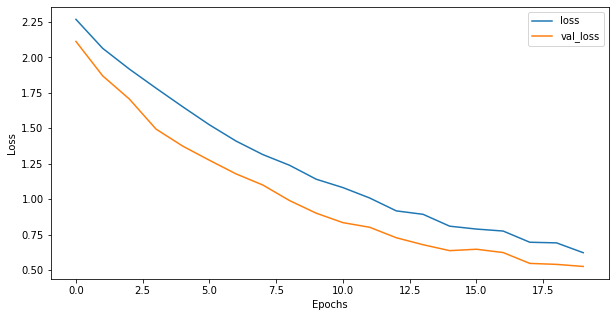

In [34]:
plt.figure(figsize=(10,5))
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

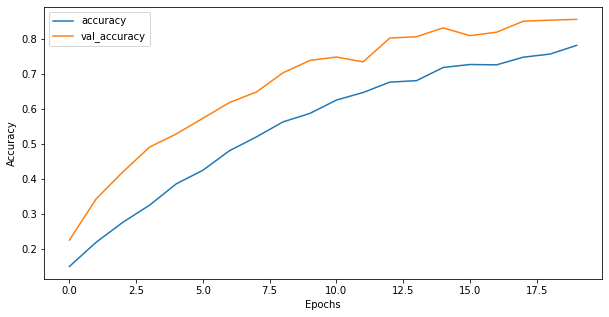

In [35]:
plt.figure(figsize=(10,5))
plt.plot(results.history["accuracy"], label="accuracy")
plt.plot(results.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
#Daha iyi sonuçlar elde edebilmek için parametreleri değiştirip tekrar bir model kurduk.

In [39]:
model2=tf.keras.Sequential()
model2.add(tf.keras.layers.Conv2D(32,
                                 kernel_size=(3,3),
                                 strides=(1,1),
                                 padding="valid",
                                 activation="relu",
                                 input_shape=(100,100,1))) 
model2.add(tf.keras.layers.Conv2D(64,
                                 kernel_size=(3,3),
                                 strides=(1,1),
                                 padding="valid",
                                 activation="relu"))
model2.add(tf.keras.layers.MaxPool2D((2,2)))
model2.add(tf.keras.layers.Conv2D(128,
                                 kernel_size=(3,3),
                                 strides=(1,1),
                                 padding="valid",
                                 activation="relu"))
model2.add(tf.keras.layers.MaxPool2D((2,2)))

model2.add(tf.keras.layers.Flatten())
model2.add(tf.keras.layers.Dense(128, activation="relu"))
model2.add(tf.keras.layers.Dropout(0.7))
model2.add(tf.keras.layers.Dense(256, activation="relu"))
model2.add(tf.keras.layers.Dropout(0.7))
model2.add(tf.keras.layers.Dense(10, activation="softmax"))

In [40]:
model2.compile(optimizer="adam",metrics=["accuracy"], loss="sparse_categorical_crossentropy")

In [41]:
results2=model2.fit(X_train, y_train, batch_size=64, epochs=20, validation_data=(X_val, y_val))

Epoch 1/20
96/96 [==============================] - 7s 62ms/step - loss: 2.1213 - accuracy: 0.2053 - val_loss: 1.7616 - val_accuracy: 0.3534
Epoch 2/20
96/96 [==============================] - 6s 58ms/step - loss: 1.7733 - accuracy: 0.3420 - val_loss: 1.3991 - val_accuracy: 0.5450
Epoch 3/20
96/96 [==============================] - 6s 60ms/step - loss: 1.4810 - accuracy: 0.4643 - val_loss: 1.0803 - val_accuracy: 0.6947
Epoch 4/20
96/96 [==============================] - 6s 58ms/step - loss: 1.2606 - accuracy: 0.5494 - val_loss: 0.8929 - val_accuracy: 0.7550
Epoch 5/20
96/96 [==============================] - 6s 58ms/step - loss: 1.1423 - accuracy: 0.5910 - val_loss: 0.7169 - val_accuracy: 0.7733
Epoch 6/20
96/96 [==============================] - 6s 58ms/step - loss: 0.9934 - accuracy: 0.6522 - val_loss: 0.6672 - val_accuracy: 0.7947
Epoch 7/20
96/96 [==============================] - 6s 58ms/step - loss: 0.8874 - accuracy: 0.6880 - val_loss: 0.6383 - val_accuracy: 0.8153
Epoch 8/20
96

In [ ]:
#Yeni metriklerle oluşturulan 2. modelin sonuçları:

In [45]:
test_accuracy2=model2.evaluate(X_test,y_test,verbose=0)
print(test_accuracy2[1])

0.8954198360443115


In [46]:
train_loss_score2=model2.evaluate(X_train,y_train,verbose=0)
test_loss_score2=model2.evaluate(X_test,y_test,verbose=0)
print(train_loss_score2)
print(test_loss_score2)

[0.062189731746912, 0.9883835315704346]
[0.37745264172554016, 0.8954198360443115]


In [ ]:
#Oluşturulan ilk CNN modeli ile parametrelerini değiştirdiğimiz CNN modelinin karşılaştırması yapılmıştır. 2. model daha iyi sonuçlar vermiştir.

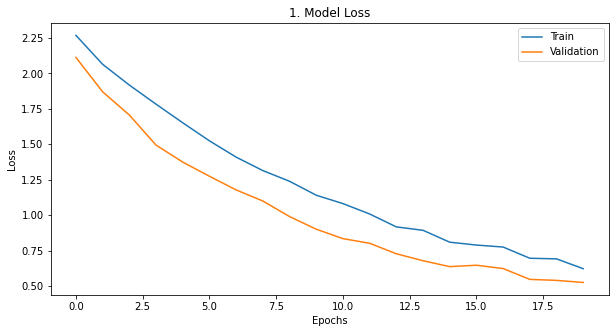

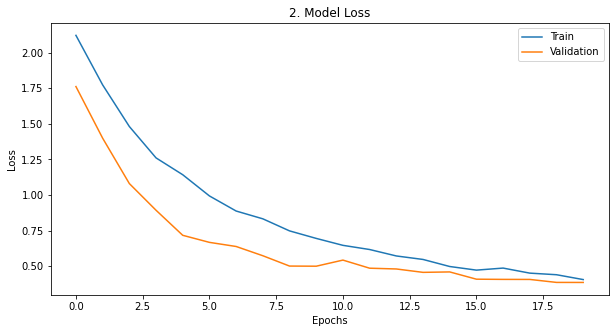

In [42]:
plt.figure(figsize=(10,5))
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.title('1. Model Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()
plt.figure(figsize=(10,5))
plt.plot(results2.history["loss"], label="loss")
plt.plot(results2.history["val_loss"], label="val_loss")
plt.title('2. Model Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

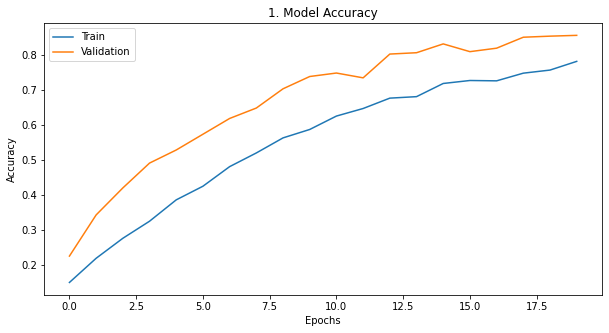

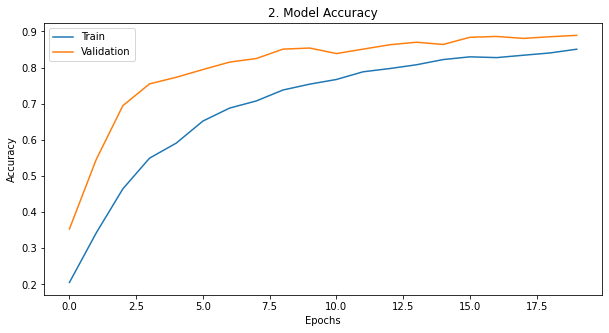

In [43]:
plt.figure(figsize=(10,5))
plt.plot(results.history["accuracy"], label="accuracy")
plt.plot(results.history["val_accuracy"], label="val_accuracy")
plt.title('1. Model Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
plt.figure(figsize=(10,5))
plt.plot(results2.history["accuracy"], label="accuracy")
plt.plot(results2.history["val_accuracy"], label="val_accuracy")
plt.title('2. Model Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()